# Import libraries

In [111]:
from time import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import numpy as np
import os
import optuna


# Load Human Activity Recognition Using Smartphones

In [112]:
# Load the data
# Set the path to the UCI HAR Dataset folder
data_folder = "/Users/davepipon/Documents/AI221_A9/UCI HAR Dataset"

# Load training data
X_train = np.loadtxt(os.path.join(data_folder, "train", "X_train.txt"))
y_train = np.loadtxt(os.path.join(data_folder, "train", "y_train.txt"), dtype=int)

# Load test data
X_test = np.loadtxt(os.path.join(data_folder, "test", "X_test.txt"))
y_test = np.loadtxt(os.path.join(data_folder, "test", "y_test.txt"), dtype=int)

# Check data

In [113]:

# Display basic information about the dataset
print("Basic Information:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Check for missing values
print("\nMissing Values:")
print("X_train missing values:", np.isnan(X_train).sum())
print("X_test missing values:", np.isnan(X_test).sum())
print("y_train missing values:", np.isnan(y_train).sum())
print("y_test missing values:", np.isnan(y_test).sum())

Basic Information:
X_train shape: (7352, 561)
X_test shape: (2947, 561)
y_train shape: (7352,)
y_test shape: (2947,)

Missing Values:
X_train missing values: 0
X_test missing values: 0
y_train missing values: 0
y_test missing values: 0


# Neural Network

## Fully-connected neural network

### Preprocessing

In [114]:
# Scale features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert labels to one-hot encoding
he = OneHotEncoder()
y_train_cat = he.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_cat = he.transform(y_test.reshape(-1, 1)).toarray()

print("\nOne-hot encoding:")
print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)



One-hot encoding:
y_train_cat shape: (7352, 6)
y_test_cat shape: (2947, 6)


### Stratified split data for training and validation

In [115]:
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_scaled, y_train_cat,
    test_size=0.3,
    stratify=y_train,
    random_state=42
)

print("\nTraining Set:")
print("X_train_part shape:", X_train_part.shape)
print("y_train_part shape:", y_train_part.shape)

print("\nValidation Set:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


Training Set:
X_train_part shape: (5146, 561)
y_train_part shape: (5146, 6)

Validation Set:
X_val shape: (2206, 561)
y_val shape: (2206, 6)


### Build fully-connected neural network

#### Optimize hyperparameters

In [116]:
input_dim = X_train.shape[1]
epoch_input = 1000
trial_count = 20

start = time()

# Build objective function for training
def obj(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)
    n_batch = trial.suggest_int('n_batch', 64, 128)
    n_units1 = trial.suggest_int('n_units1', 256, 512)
    n_units2 = trial.suggest_int('n_units2', 64, 128)
    n_patience = trial.suggest_int('n_patience', 5, 10)

    # Build fully-connected neural network
    nn_trial = Sequential([ Input(shape=(input_dim,)),
    Dense(n_units1, activation='relu'),
    Dense(n_units2, activation='relu'),
    Dense(6, activation='softmax')])

    # Early stopping to prevent overtraining
    early_trial = EarlyStopping(monitor='val_loss', patience=n_patience, restore_best_weights=True)

    # Compile the model
    nn_trial.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Train the autoencoder
    history_nn_trial = nn_trial.fit(X_train_part, y_train_part, epochs=1000, batch_size=n_batch, callbacks=[early_trial],
                            validation_data=(X_val, y_val), verbose=0)

    # Return the best validation loss
    return min(history_nn_trial.history['val_loss'])

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(obj, n_trials=trial_count)

print("Best trial:")
best_trial = study.best_trial
print("  Validation Loss: {:.5f}".format(best_trial.value))
print("  Best hyperparameters: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

print(f"Execution time: {time()-start} sec")

[I 2025-03-30 00:45:39,139] A new study created in memory with name: no-name-7f9e751d-54c1-4706-8d52-fa3f756c4990
[I 2025-03-30 00:45:48,583] Trial 0 finished with value: 0.04705805703997612 and parameters: {'learning_rate': 0.0003973920755810587, 'n_batch': 119, 'n_units1': 475, 'n_units2': 125, 'n_patience': 8}. Best is trial 0 with value: 0.04705805703997612.
[I 2025-03-30 00:46:03,920] Trial 1 finished with value: 0.04370887205004692 and parameters: {'learning_rate': 9.354744285252484e-05, 'n_batch': 91, 'n_units1': 386, 'n_units2': 106, 'n_patience': 6}. Best is trial 1 with value: 0.04370887205004692.
[I 2025-03-30 00:46:09,654] Trial 2 finished with value: 0.05721550062298775 and parameters: {'learning_rate': 0.01058664868140575, 'n_batch': 121, 'n_units1': 283, 'n_units2': 83, 'n_patience': 9}. Best is trial 1 with value: 0.04370887205004692.
[I 2025-03-30 00:46:19,260] Trial 3 finished with value: 0.046043507754802704 and parameters: {'learning_rate': 0.0002449660455403209, 'n

Best trial:
  Validation Loss: 0.04218
  Best hyperparameters: 
    learning_rate: 0.0004039140495061234
    n_batch: 113
    n_units1: 429
    n_units2: 95
    n_patience: 6
Execution time: 287.7400269508362 sec


#### Build optimized neural network

In [117]:
start = time()

# Store optimizied hyperparameters
best_params = best_trial.params

# Build fully-connected neural network
fcnn = Sequential([Input(shape=(input_dim,)),
    Dense(best_params['n_units1'], activation='relu'),
    Dense(best_params['n_units2'], activation='relu'),
    Dense(6, activation='softmax')])

# Early stopping to prevent overtraining
early_stop_fcnn = EarlyStopping(monitor='val_loss', patience=best_params['n_patience'], restore_best_weights=True)

# Compile the model
fcnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=best_params['learning_rate']), metrics=['accuracy'])
fcnn.summary()

# Train the optimize model
history_fcnn = fcnn.fit(X_train_part, y_train_part, epochs=epoch_input, batch_size=best_params['n_batch'], 
                        callbacks=[early_stop_fcnn],
                        validation_data=(X_val, y_val), verbose=1)

print(f"Execution time: {time()-start} sec")

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_297 (Dense)               │ (None, 429)            │       241,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 95)             │        40,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 6)              │           576 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,524 (1.08 MB)

 Trainable params: 282,524 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6466 - loss: 0.8992 - val_accuracy: 0.9365 - val_loss: 0.1788
Epoch 2/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9539 - loss: 0.1473 - val_accuracy: 0.9628 - val_loss: 0.1054
Epoch 3/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9739 - loss: 0.0858 - val_accuracy: 0.9714 - val_loss: 0.0836
Epoch 4/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9818 - loss: 0.0622 - val_accuracy: 0.9769 - val_loss: 0.0690
Epoch 5/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9894 - loss: 0.0424 - val_accuracy: 0.9705 - val_loss: 0.0699
Epoch 6/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9891 - loss: 0.0411 - val_accuracy: 0.9796 - val_loss: 0.0602
Epoch 7/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9908 - loss: 0.0343 - val_accuracy: 0.9751 - val_loss: 0.0676
Epoch 8/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0260 - val_accuracy: 0

### Test model

Test Accuracy: 94.57%


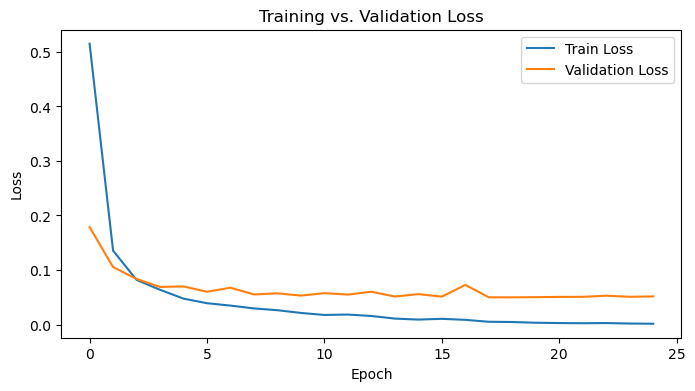

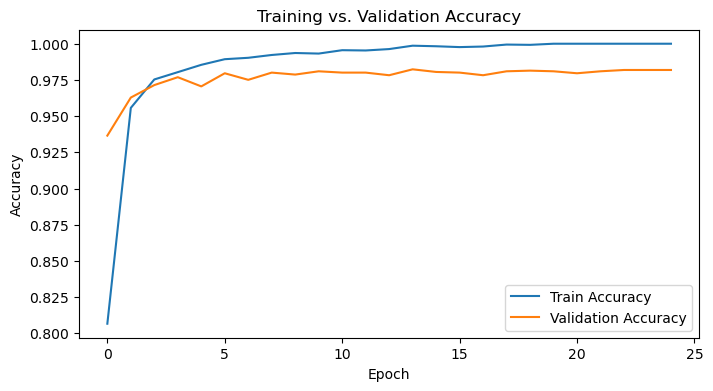

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_pred shape: (2947, 6)
y_pred shape: (2947,)


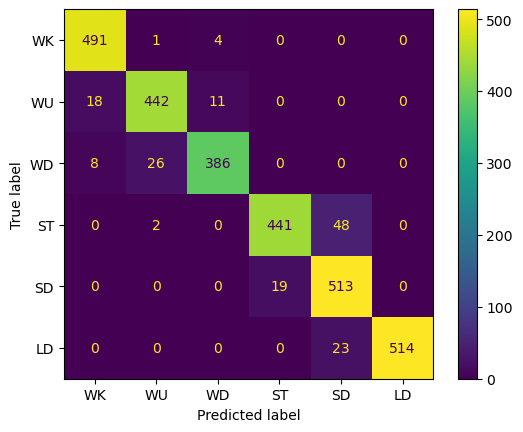

              precision    recall  f1-score   support

          WK       0.95      0.99      0.97       496
          WU       0.94      0.94      0.94       471
          WD       0.96      0.92      0.94       420
          ST       0.96      0.90      0.93       491
          SD       0.88      0.96      0.92       532
          LD       1.00      0.96      0.98       537

    accuracy                           0.95      2947
   macro avg       0.95      0.94      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [118]:
# Display test loss and accuracy
test_loss, test_acc = fcnn.evaluate(X_test_scaled, y_test_cat, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

# Display the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_fcnn.history['loss'], label='Train Loss')
plt.plot(history_fcnn.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_fcnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_fcnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

# Predict the test set
y_pred = fcnn.predict(X_test_scaled)
print("y_pred shape:", y_pred.shape)
y_pred = he.inverse_transform(y_pred)
y_pred = y_pred.flatten()
print("y_pred shape:", y_pred.shape)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['WK', 'WU', 'WD', 'ST', 'SD', 'LD'])
disp.plot()
plt.show()

# Display the classification report
cr = classification_report(y_test, y_pred, target_names=['WK', 'WU', 'WD', 'ST', 'SD', 'LD'])
print(cr)

## Autoencoder

### Train for dimension reduction

In [119]:
start = time()
input = 10

# Build encoder model
encoder = Sequential([Input(shape=(input_dim,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(input, name='bottleneck')
], name='encoder')

# Build decoder model
decoder = Sequential([Input(shape=(input,)),
Dense(64, activation='relu'),
Dense(128, activation='relu'),
Dense(input_dim)
], name='decoder')

# Create the autoencoder by chaining the encoder and decoder
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
autoencoder.summary()

# Early stopping to prevent overtraining
early_stop_ae = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the autoencoder
history_ae = autoencoder.fit(X_train_part, X_train_part, epochs=100, validation_data=(X_val, X_val),
                         callbacks=[early_stop_ae], verbose=1)

# Get the encoded representations
X_train_sae = encoder.predict(X_train_part)
X_val_sae = encoder.predict(X_val)
X_test_sae = encoder.predict(X_test_scaled)

print(f"Execution time: {time()-start} sec")

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 10)             │        80,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 561)            │        81,393 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,235 (633.73 KB)

 Trainable params: 162,235 (633.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5923 - val_loss: 0.3394
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3217 - val_loss: 0.2938
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2815 - val_loss: 0.2747
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2744 - val_loss: 0.2638
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2545 - val_loss: 0.2571
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2487 - val_loss: 0.2566
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2432 - val_loss: 0.2501
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2411 - val_loss: 0.2450
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2340 - val_loss: 0.2459
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2338 - val_loss: 0.2417
Epoch 11/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2270 - val_loss: 0.2382
Epoch 12/100
161/161 ━━━━━━━━━━━━━━━━━━━━

### Optimize hyperparameters

In [120]:
input_dim = X_train_sae.shape[1]  # Update input_dim to match the reduced dimensionality

start = time()

# Build objective function for training
def obj_dr(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    n_batch = trial.suggest_int('n_batch', 64, 128)
    n_units1 = trial.suggest_int('n_units1', 256, 512)
    n_units2 = trial.suggest_int('n_units2', 64, 128)
    n_patience = trial.suggest_int('n_patience', 5, 10)

    # Build fully-connected neural network
    nn_trial = Sequential([Input(shape=(input_dim,)),
                            Dense(n_units1, activation='relu'),
                            Dense(n_units2, activation='relu'),
                            Dense(6, activation='softmax')])

    # Early stopping to prevent overtraining
    early_trial = EarlyStopping(monitor='val_loss', patience=n_patience, restore_best_weights=True)

    # Compile the model
    nn_trial.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Train the autoencoder
    history_nn_trial = nn_trial.fit(X_train_sae, y_train_part, epochs=1000, batch_size=n_batch, callbacks=[early_trial],
                                    validation_data=(X_val_sae, y_val), verbose=0)

    # Return the best validation loss
    return min(history_nn_trial.history['val_loss'])

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(obj_dr, n_trials=trial_count)

print("Best trial:")
best_trial = study.best_trial
print("  Validation Loss: {:.5f}".format(best_trial.value))
print("  Best hyperparameters: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

print(f"Execution time: {time()-start} sec")

[I 2025-03-30 00:51:15,487] A new study created in memory with name: no-name-1b1881c8-c0e5-4ba1-8500-8f40dcdfe8b7


[I 2025-03-30 00:51:20,933] Trial 0 finished with value: 0.16005121171474457 and parameters: {'learning_rate': 0.003046237357464175, 'n_batch': 66, 'n_units1': 356, 'n_units2': 118, 'n_patience': 8}. Best is trial 0 with value: 0.16005121171474457.
[I 2025-03-30 00:51:27,445] Trial 1 finished with value: 0.15753823518753052 and parameters: {'learning_rate': 0.01734572535255315, 'n_batch': 121, 'n_units1': 410, 'n_units2': 95, 'n_patience': 7}. Best is trial 1 with value: 0.15753823518753052.
[I 2025-03-30 00:51:31,467] Trial 2 finished with value: 0.2749784588813782 and parameters: {'learning_rate': 0.08170328425031088, 'n_batch': 84, 'n_units1': 399, 'n_units2': 125, 'n_patience': 8}. Best is trial 1 with value: 0.15753823518753052.
[I 2025-03-30 00:51:37,215] Trial 3 finished with value: 0.1560845822095871 and parameters: {'learning_rate': 0.002356008103350853, 'n_batch': 75, 'n_units1': 419, 'n_units2': 122, 'n_patience': 6}. Best is trial 3 with value: 0.1560845822095871.
[I 2025-0

Best trial:
  Validation Loss: 0.14012
  Best hyperparameters: 
    learning_rate: 4.052027042051544e-05
    n_batch: 102
    n_units1: 274
    n_units2: 117
    n_patience: 8
Execution time: 564.2897338867188 sec


### Build optimize neural network

In [121]:
start = time()

# Store optimizied hyperparameters
best_params = best_trial.params

# Build fully-connected neural network
fcnn = Sequential([Input(shape=(input_dim,)),
    Dense(best_params['n_units1'], activation='relu'),
    Dense(best_params['n_units2'], activation='relu'),
    Dense(6, activation='softmax')])

# Early stopping to prevent overtraining
early_stop_fcnn = EarlyStopping(monitor='val_loss', patience=best_params['n_patience'], restore_best_weights=True)

# Compile the model
fcnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=best_params['learning_rate']), metrics=['accuracy'])
fcnn.summary()

# Train the optimize model
history_fcnn = fcnn.fit(X_train_sae, y_train_part, epochs=epoch_input, batch_size=best_params['n_batch'], 
                        callbacks=[early_stop_fcnn],
                        validation_data=(X_val_sae, y_val), verbose=1)

print(f"Execution time: {time()-start} sec")

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_365 (Dense)               │ (None, 274)            │         3,014 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 117)            │        32,175 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 6)              │           708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,897 (140.22 KB)

 Trainable params: 35,897 (140.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1488 - loss: 2.3730 - val_accuracy: 0.4370 - val_loss: 1.6972
Epoch 2/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5068 - loss: 1.5410 - val_accuracy: 0.6460 - val_loss: 1.1541
Epoch 3/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6612 - loss: 1.0755 - val_accuracy: 0.7348 - val_loss: 0.8689
Epoch 4/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7437 - loss: 0.8251 - val_accuracy: 0.7906 - val_loss: 0.7034
Epoch 5/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8028 - loss: 0.6757 - val_accuracy: 0.8450 - val_loss: 0.5977
Epoch 6/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.5793 - val_accuracy: 0.8726 - val_loss: 0.5243
Epoch 7/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8598 - loss: 0.5138 - val_accuracy: 0.8808 - val_loss: 0.4698
Epoch 8/1000
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8696 - loss: 0.4670 - val_accuracy: 0.

### Test model

Test Accuracy: 87.82%


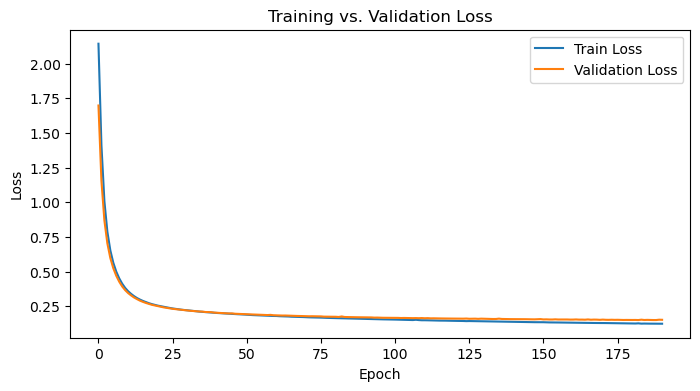

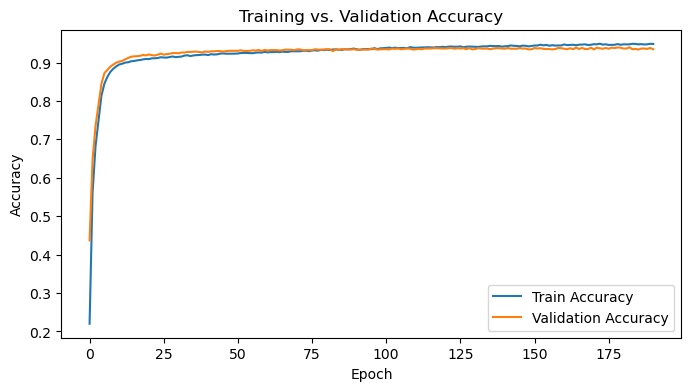

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
y_pred shape: (2947, 6)
y_pred shape: (2947,)


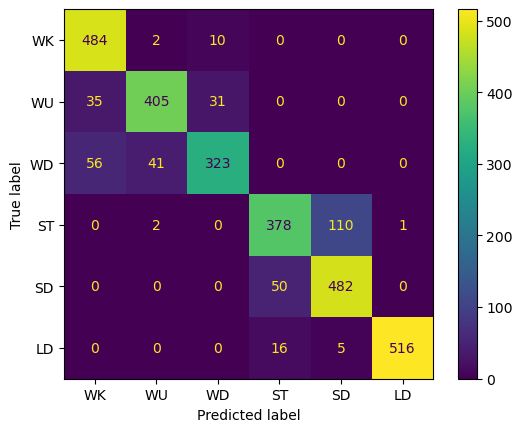

              precision    recall  f1-score   support

          WK       0.84      0.98      0.90       496
          WU       0.90      0.86      0.88       471
          WD       0.89      0.77      0.82       420
          ST       0.85      0.77      0.81       491
          SD       0.81      0.91      0.85       532
          LD       1.00      0.96      0.98       537

    accuracy                           0.88      2947
   macro avg       0.88      0.87      0.87      2947
weighted avg       0.88      0.88      0.88      2947



In [122]:
# Display test loss and accuracy
test_loss, test_acc = fcnn.evaluate(X_test_sae, y_test_cat, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

# Display the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_fcnn.history['loss'], label='Train Loss')
plt.plot(history_fcnn.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_fcnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_fcnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.show()

# Predict the test set
y_pred = fcnn.predict(X_test_sae)
print("y_pred shape:", y_pred.shape)
y_pred = he.inverse_transform(y_pred)
y_pred = y_pred.flatten()
print("y_pred shape:", y_pred.shape)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['WK', 'WU', 'WD', 'ST', 'SD', 'LD'])
disp.plot()
plt.show()

# Display the classification report
cr = classification_report(y_test, y_pred, target_names=['WK', 'WU', 'WD', 'ST', 'SD', 'LD'])
print(cr)

# Conclusion

While the MC-SVM of Anguita, et al (2013) still has the highest accruracy versus the developed neural networks, the difference is close to nil with the optimized fully-connected neural network using unreduced feature space. Notably, the reduce feature space performs bad compared to unreduced feature space fully-connected neural network. The differences across models are observed when predicting sitting and standing labels.